In [1]:
# Import libraries

import numpy as np
import pickle
import tensorflow as tf
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [3]:
# Function to load X values
def load_depth_inputs():
    X_train_depth = pickle.load(open('E:/training_depth.pkl', "rb"))
    X_valid_depth = pickle.load(open('E:/validation_depth.pkl', "rb"))
    X_test_depth = pickle.load(open('E:/testing_depth.pkl', "rb"))
    return X_train_depth, X_valid_depth, X_test_depth

# Function to load y values
def load_outputs():
    y_train = pickle.load(open('E:/y_training.pkl', "rb"))
    y_valid = pickle.load(open('E:/y_validation.pkl', "rb"))
    y_test = pickle.load(open('E:/y_testing.pkl', "rb"))
    return y_train, y_valid, y_test

# Function to reshape data
def reshape_input_vect(vect, size=(128, 64, 3)):
    inp_vect = []
    for i in range(vect.shape[0]):
        inp_vect.append(np.reshape(vect[i], (128, 64, 3)))
    return np.asarray(inp_vect)

# Load in X data
X_train_depth, X_valid_depth, X_test_depth = load_depth_inputs()

# Load in y data
y_train_depth, y_valid_depth, y_test_depth = load_outputs()

# To categorical y-values [[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]]
y_train_depth = to_categorical(y_train_depth, num_classes = None, dtype='float32')
y_valid_depth = to_categorical(y_valid_depth, num_classes = None, dtype='float32')
y_test_depth = to_categorical(y_test_depth, num_classes = None, dtype='float32')

In [4]:
# Shuffle data
np.random.seed(200)
X_train_depth, X_valid_depth, X_test_depth = np.random.permutation(X_train_depth), np.random.permutation(
    X_valid_depth), np.random.permutation(X_test_depth)
np.random.seed(200)
y_train_depth, y_valid_depth, y_test_depth = np.random.permutation(y_train_depth), np.random.permutation(
    y_valid_depth), np.random.permutation(y_test_depth)

In [5]:
# Reshape data
X_train_depth, X_valid_depth, X_test_depth = reshape_input_vect(X_train_depth), reshape_input_vect(X_valid_depth), reshape_input_vect(X_test_depth)
print("new shape:", X_train_depth.shape)
print("new shape:", X_valid_depth.shape)
print("new shape:", X_test_depth.shape)

new shape: (1920, 128, 64, 3)
new shape: (640, 128, 64, 3)
new shape: (640, 128, 64, 3)


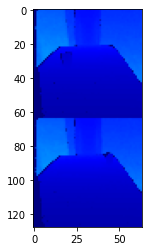

In [6]:
# Show first training image
plt.imshow(X_train_depth[0])
plt.show()

In [11]:
### CNN MODEL

model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(32, (5, 5), activation='relu', input_shape=(128, 64, 3)))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(4, activation='softmax'))

model.summary()

model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train_depth, y_train_depth, epochs=20, verbose=1, validation_data=(X_valid_depth, y_valid_depth))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 124, 60, 32)       2432      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 62, 30, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 60, 28, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 30, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 28, 12, 128)       73856     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 14, 6, 128)      

In [12]:
[loss, acc] = model.evaluate(X_valid_depth, y_valid_depth ,verbose=1)
print("Accuracy:" + str(acc))

20/20 [==============================] - 0s 7ms/step - loss: 0.1341 - accuracy: 0.9703
Accuracy:0.9703124761581421


In [14]:
model.evaluate(X_test_depth, y_test_depth)

20/20 [==============================] - 0s 7ms/step - loss: 0.2680 - accuracy: 0.9531


[0.26800069212913513, 0.953125]

In [15]:
model.save('CNN_1_depth_model',save_format='h5')

In [16]:
model = tf.keras.models.load_model('CNN_1_depth_model')

In [17]:
# Predict the values from the validation dataset and convert predictions classes to one hot vectors
categories = ['Left to right', "Pull", "Push", "Right to left"]
y_pred = np.argmax(model.predict(X_test_depth), axis=-1)

# Convert validation observations to one hot vectors
y_true = np.argmax(y_test_depth, axis=-1)

print(classification_report(y_true, y_pred, target_names=categories, digits=4))

20/20 [==============================] - 0s 5ms/step
               precision    recall  f1-score   support

Left to right     0.9487    0.9250    0.9367       160
         Pull     0.9029    0.9875    0.9433       160
         Push     0.9805    0.9437    0.9618       160
Right to left     0.9871    0.9563    0.9714       160

     accuracy                         0.9531       640
    macro avg     0.9548    0.9531    0.9533       640
 weighted avg     0.9548    0.9531    0.9533       640



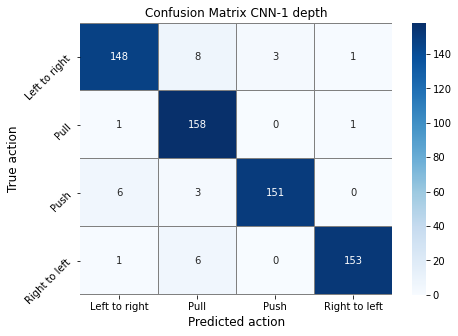

In [18]:
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred) 
# plot the confusion matrix
categories = ['Left to right', "Pull", "Push", "Right to left"]
f, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Blues",linecolor="grey", fmt= 'g',ax=ax, xticklabels=categories, yticklabels=categories)
plt.xlabel("Predicted action", fontsize=12)
plt.ylabel("True action", fontsize=12)
plt.title("Confusion Matrix CNN-1 depth")
locs, labels = plt.yticks()
plt.setp(labels, rotation=45)
plt.show()